# Link to the lab

https://tinyurl.com/y6cskbl6

# Adding a CRF to your pytorch models

In this lab we'll go over how you can easily add a CRF layer to your PyTorch models. We will also briefly touch on how the CRF works so you can gain an understanding of what is going on when you train and run inference with these models. Fortunately its only a few lines of code to add a CRF using this third party library: [pytorch-crf](https://pytorch-crf.readthedocs.io/en/stable/). If you would like a more advanced implementation, you can also take a look at the [AllenNLP CRF module](https://github.com/allenai/allennlp/blob/master/allennlp/modules/conditional_random_field.py)

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTffl57kMgiYxRXlLp26zdz8yfkaxjJR_EvZg&usqp=CAU)

## At a high level...

A conditional random field (CRF) is a method one can use to learn from and perform inference on data whose predictions depend on each other. It is a type of graphical model where the nodes are the individual observations you wish to make predictions on and the edges are dependencies between the nodes. In practical settings where, for example, you wish to make predictions on a sentence at the token level, the prediction you make for one token can change your belief about the other tokens. A graphical model like a CRF allows you to model these dependencies. Unfortunately, trying to model the dependencies between each node in an arbitrarily sized graph is combinatorial and thus intractable, so we have to make some simplifying assumptions.

One of the most common simplifications, and the one you will use in your project, is to assume that your data is structured as a sequence, and that your prediction at time $t$ is only dependent on your prediction at time $t - 1$. When modeled using a CRF, this is called a **linear chain CRF**. With a linear chain CRF, you make predictions by modeling two things: the probability of a label given your input ($p(y_{t}|X)$), and the probability of a label given the previous label ($p(y_t|y_{t-1})$).

In the BiLSTM-CRF, the input probabilities $p(y_t|X)$ are modeled using the BiLSTM, and the probabilities $p(y_t|y_{t-1})$ are modeled using a transition matrix $V$ of size $n \times n$ where $n$ is the number of tags (i.e., one transition probability for each possible transition). In practice, this means you simply need to add a CRF on top of your BiLSTM output logits instead of using a softmax and cross-entropy on the BiLSTM logits.

![](https://www.gabormelli.com/RKB/images/thumb/1/1e/N16-1030_fig1.png/400px-N16-1030_fig1.png)
[Source](https://www.aclweb.org/anthology/N16-1030.pdf)

The model is then trained by maximizing the log-likelihood (i.e. minimizing the negative log-likelihood) of the entire sequence. For more in depth explanation of how this is performed, see the lectures from Hugo Larochelle [here](https://www.youtube.com/watch?v=PGBlyKtfB74&ab_channel=HugoLarochelle).

## Install external packages

We'll use fasttext wiki embeddings in our embedding layer, and pytorch-crf to add a CRF to our BiLSTM.

In [1]:
!pip install fasttext
!pip install pytorch-crf

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Also in this lab...

We'll go over one more neural network trick and how you can use it in PyTorch: setting a learning rate schedule.

In [3]:
import io
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

Let's download some fasttext vectors to serve as our input word embeddings.

In [5]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2020-10-08 11:47:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M  10.7MB/s    in 62s     

2020-10-08 11:48:59 (10.5 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Named entity recognition

We'll use a relatively small dataset from wikipedia for **named entity recognition (NER)**. NER is a sequence labelling problem where we want to identify the **entities** that appear in a document and their types. For example, we could have the following sentence: *Sundar Pichai is the CEO of Alphabet, located in Mountain View, CA.* We want to be able to extract from this sentence all of the people, locations, and organizations; namely, that *Sundar Pichai* is a person, *Alphabet* is an organization, and *Mountain View, CA* is a location. One possible way to do this is to make the following predictions on the individual tokens in the sentence:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
  </tr>
</tbody>
</table>

Here we have labelled all of the tokens associate with their classes as the given type (PER: Person, ORG: Organization, LOC: Location, O: Outside). **Question: What are some issues that could arise as a result of this tagging?**

In practice, we will also want to denote which tokens are the beginning of an entity, and which tokens are inside the full entity span, giving the following tagging:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">B-PER</td>
    <td class="tg-0pky">I-PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">B-ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
  </tr>
</tbody>
</table>

This is commonly known as IOB tagging. There are other tagging schemes which are used in practice as well. **Question: What are some other tagging schemes that you think could be good?**

Hopefully it is clear why modeling the dependencies between the predictions can be useful: for example knowing that the previous tag was `B-PER` influences whether or not the current tag will be `I-PER` or `O` or `I-LOC`.

## Download the data

In this lab we'll use a small set of wikipedia data labelled with people, locations, organizations, and "miscellaneous" entities. Download the data here.

In [6]:
!wget https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/wikigold/CONLL-format/data/wikigold.conll.txt

--2020-10-08 11:49:40--  https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/wikigold/CONLL-format/data/wikigold.conll.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318530 (311K) [text/plain]
Saving to: ‘wikigold.conll.txt.1’

wikigold.conll.txt. 100%[===================>] 311.06K  --.-KB/s    in 0.005s  

2020-10-08 11:49:41 (64.8 MB/s) - ‘wikigold.conll.txt.1’ saved [318530/318530]



Reading in the data, the data doesn't have B tags so we'll add them as best we can.

In [7]:
def read_data(filename, splitchar = '\t'):
  dataset = []
  with open(filename) as f:
    data = f.read()
    samples = data.split('\n\n')
    for s in samples:
      if s and '-DOCSTART-' not in s:
        tok_idx = [t.split(splitchar) for t in s.strip().split('\n')]
        tokens,idx = zip(*tok_idx)
        tokens = list(tokens)
        idx = list(idx)
        j = 0
        # Convert to IOB
        while j < len(idx):
          if idx[j][0] == 'I' and (j == 0 or idx[j-1][0] == 'O'):
            idx[j] = 'B' + idx[j][1:]
          j += 1
        dataset.append([tokens,idx])
  return dataset

In [8]:
data = read_data('wikigold.conll.txt', splitchar = ' ')

Here we'll create train, dev, and test splits.

In [9]:
random.shuffle(data)
test_idx = int(len(data)*0.9)
test_data = data[test_idx:]
train_data = data[:test_idx]
val_idx = int(0.9*len(train_data))
dev_data = train_data[val_idx:]
train_data = train_data[:val_idx]

In [10]:
[(t, l) for t,l in zip(train_data[5][0], train_data[5][1])]

[('His', 'O'),
 ('events', 'O'),
 ('have', 'O'),
 ('been', 'O'),
 ('featured', 'O'),
 ('on', 'O'),
 ('Deco', 'B-PER'),
 ('Drive', 'I-PER'),
 ("'s", 'O'),
 ('Party', 'B-MISC'),
 ('Patrol', 'I-MISC'),
 ('on', 'O'),
 ('FOX', 'B-ORG'),
 ('7', 'I-ORG'),
 (',', 'O'),
 ('Telemundo', 'B-ORG'),
 (',', 'O'),
 ('Univision', 'B-ORG'),
 (',', 'O'),
 ('MUN2', 'B-ORG'),
 (',', 'O'),
 ('A3', 'B-ORG'),
 (',', 'O'),
 ('MTV', 'B-ORG'),
 ('&', 'O'),
 ('Wild', 'B-ORG'),
 ('on', 'I-ORG'),
 ('E', 'I-ORG'),
 ('!', 'I-ORG'),
 (',', 'O'),
 ('to', 'O'),
 ('name', 'O'),
 ('a', 'O'),
 ('few', 'O'),
 ('.', 'O')]

In [11]:
# Some globals which determine the number of labels and their indices
label_map = {l:i for i,l in enumerate((set([l for s in train_data for l in s[1]]) | set([l for s in dev_data for l in s[1]]) | set([l for s in test_data for l in s[1]])))}
num_labels = len(label_map)

print(label_map)

{'I-MISC': 0, 'O': 1, 'B-LOC': 2, 'I-PER': 3, 'I-ORG': 4, 'I-LOC': 5, 'B-ORG': 6, 'B-PER': 7, 'B-MISC': 8}


We'll create the word embedding space using all of the vocabulary from the train and dev splits, plus the most frequent tokens from the trained word embeddings to hopefully capture as many test tokens as possible.

In [12]:
# Reduce down to our vocabulary and word embeddings
def load_vectors(fname, vocabulary):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    final_vocab = ['[PAD]', '[UNK]', '[BOS]', '[EOS]']
    final_vectors = [np.random.normal(size=(300,)), np.random.normal(size=(300,)), np.random.normal(size=(300,)), np.random.normal(size=(300,))]
    for j,line in enumerate(fin):
        tokens = line.rstrip().split(' ')
        if tokens[0] in vocabulary or len(final_vocab) < 30000:
          final_vocab.append(tokens[0])
          final_vectors.append(np.array(list(map(float, tokens[1:]))))
    return final_vocab, np.vstack(final_vectors)

vocabulary = (set([t for s in train_data for t in s[0]]) | set([t for s in dev_data for t in s[0]]))
vocabulary, pretrained_embeddings = load_vectors('wiki-news-300d-1M.vec', vocabulary)

In [13]:
len(vocabulary)

31601

The main difference in the dataset reading and collation functions is that we now return a sequence of labels instead of a single label as in text classification.

In [14]:
def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    labels = [(i + [label_map['O']] * (max_length - len(i))) for i in labels]

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(i) == max_length for i in labels))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)


def text_to_batch_bilstm(text: List, tokenizer) -> Tuple[List, List]:
    """
    Creates a tokenized batch for input to a bilstm model
    :param text: A list of sentences to tokenize
    :param tokenizer: A tokenization function to use (i.e. fasttext)
    :return: Tokenized text as well as the length of the input sequence
    """
    # Some light preprocessing
    input_ids = [tokenizer.encode(t) for t in text]

    return input_ids, [len(ids) for ids in input_ids]


class FasttextTokenizer:
    def __init__(self, vocabulary):
        self.vocab = {}
        for j,l in enumerate(vocabulary):
            self.vocab[l.strip()] = j

    def encode(self, text):
        # Text is assumed to be tokenized
        return [self.vocab[t] if t in self.vocab else self.vocab['[UNK]'] for t in text]

# This will load the dataset and process it lazily in the __getitem__ function
class NERDatasetReader(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset[idx]
    # Calls the text_to_batch function
    input_ids,seq_lens = text_to_batch_bilstm([row[0]], self.tokenizer)
    labels = [label_map[l] for l in row[1]]
    return input_ids, seq_lens, labels


In [15]:
reader = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
dev_dl = DataLoader(reader, batch_size=1, shuffle=False, collate_fn=collate_batch_bilstm)
next(iter(dev_dl))

(tensor([[ 3285,    60,  2162,     4,  4484,   524,    52,  1111,  1192,     8,
              5,   683,  5204,     8,     5, 14131,  6158,    10,  3151,     6]]),
 tensor([20]),
 tensor([[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 4, 4, 4, 4, 4, 1, 1, 1]]))

In [16]:
print(dev_data[0])
print(vocabulary[3285],vocabulary[60],vocabulary[2162],vocabulary[4],vocabulary[4484],
      vocabulary[524],vocabulary[52],vocabulary[1111],vocabulary[1192],vocabulary[8],
      vocabulary[5],vocabulary[683],vocabulary[5204],vocabulary[8],vocabulary[5],
      vocabulary[14131],vocabulary[6158],vocabulary[10],vocabulary[3151],vocabulary[6])

[['Following', 'its', 'independence', ',', 'Bangladesh', 'became', 'an', 'independent', 'member', 'of', 'the', 'World', 'Organization', 'of', 'the', 'Scout', 'Movement', 'in', '1974', '.'], ['O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O']]
Following its independence , Bangladesh became an independent member of the World Organization of the Scout Movement in 1974 .


## Creating the model

You'll notice that the BiLSTM model is mostly the same from the text classification and language modeling labs. The differences are:

- Instead of taking a softmax/cross-entropy loss using the logits from the BiLSTM, we pass the logits to the pytorch-crf CRF module. The output of this model is the **log-likelihood of the entire sequence** (for each sequence in the batch). Since our objective is to minimize the loss, we take the **negative** of the log likelihood as our loss.
- There is now a **decode** function, which passes logits through the CRF to get the most likely tag sequences.

In [17]:
# Define the model
class BiLSTM_CRF(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM_CRF, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
            'CRF': CRF(n_classes, batch_first=True)
        })
        self.n_classes = n_classes

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens,
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get emissions (b x seq_len x n_classes)
        emissions = self.model['ff'](lstm_out)
        outputs = (emissions,)
        if labels is not None:
            mask = (inputs != 0)
            # log-likelihood from the CRF
            log_likelihood = self.model['CRF'](emissions, labels, mask=mask, reduction='token_mean')
            outputs = (-log_likelihood,) + outputs

        return outputs

    def decode(self, emissions, mask):
      """
      Given a set of emissions and a mask, decode the sequence
      """
      return self.model['CRF'].decode(emissions, mask=mask)

The evaluation function is also slightly different -- we evaluate perfomance based on the decoded sequence from the CRF as opposed to the output of the BiLSTM. We use macro-F1 score for this.

In [18]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  tags_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      mask = (input_ids != 0)
      labels_all.extend([l for seq,samp in zip(list(labels.detach().cpu().numpy()), input_ids) for l,i in zip(seq,samp) if i != 0])
      logits_all.extend(list(logits.detach().cpu().numpy()))
      
      tags = model.decode(logits, mask)
      tags_all.extend([t for seq in tags for t in seq])

    P, R, F1, _ = precision_recall_fscore_support(labels_all, tags_all, average='macro')

    return F1

## Learning rate schedules

In practical machine learning settings, it is oftentime beneficial to change the learning rate in some way to speed up training or to train a better model. PyTorch makes this super easy: simply use one of their learning rate schedulers form `torch.optim.lr_schedule`, and add a line in your training loop which calls the `step()` function of your scheduler. This will automatically change your learning rate! **Note**: be aware of when to call `step()`; some schedulers change the learning rate after every epoch, and some change after every training step (batch). The one we will use here changes the learning rate after every training step. We'll define the scheduler in the cell that calls the `train()` function. 

In [19]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler=None
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  learning_rates = []
  best_f1 = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler != None:
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr()[0])
        
    #gc.collect()

    # Perform inline evaluation at the end of the epoch
    f1 = evaluate(model, valid_dl)
    print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if f1 > best_f1:
      torch.save(model.state_dict(), 'best_model')
      best_f1 = f1
        #gc.collect()

  return losses, learning_rates

Set up hyperparameters and create the model. Note the high learning rate -- this is partially due to the learning rate scheduler we will use.

In [20]:
lstm_dim = 128
dropout_prob = 0.1
batch_size = 8
lr = 1e-2
n_epochs = 10

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the model
model = BiLSTM_CRF(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(label_map)
  ).to(device)

Here we get the data loaders and create the optimizer and learning rate scheduler. The scheduler we will use is the `CyclicLR` scheduler. The cyclic learning rate schedule in general looks like this:

![](https://ai-how.github.io/img/CLR.png) [Source](https://arxiv.org/pdf/1506.01186.pdf)

We are using it here to linearly decay the learning rate from a starting max learning rate (here 1e-2) down to 0 over the entire course of training (essentially one cycle that starts at the max and ends at 0).

In [21]:
# Create the dataset readers
train_dataset = NERDatasetReader(train_data, FasttextTokenizer(vocabulary))
# dataset loaded lazily with N workers in parallel
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)

valid_dataset = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
valid_dl = DataLoader(valid_dataset, batch_size=len(dev_data), collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

# Train
losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)
model.load_state_dict(torch.load('best_model'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validation F1: 0.6975524436494466, train loss: 0.3430858288220195



Validation F1: 0.8119963228333955, train loss: 0.12238033348694444



Validation F1: 0.7817683054899062, train loss: 0.07441913911552969



Validation F1: 0.8200773499651753, train loss: 0.05000679780794091



Validation F1: 0.835723297819488, train loss: 0.030835414281978574



Validation F1: 0.8475326137900652, train loss: 0.02097943685370156



Validation F1: 0.8458376646949924, train loss: 0.013777822534182126



Validation F1: 0.8288020677196645, train loss: 0.009474778172917404



Validation F1: 0.8291131169960992, train loss: 0.006319943406493241



Validation F1: 0.8291131169960992, train loss: 0.004353055404778367


<All keys matched successfully>

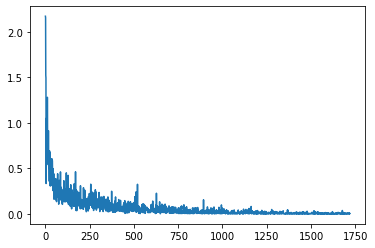

In [22]:
plt.plot(losses)

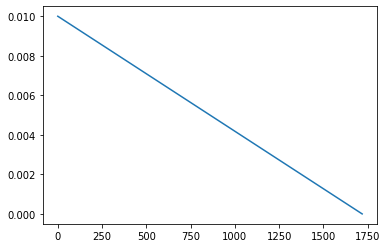

In [23]:
plt.plot(learning_rates)

In [24]:
test_dataset = NERDatasetReader(test_data, FasttextTokenizer(vocabulary))
test_dl = DataLoader(test_dataset, batch_size=len(test_data), collate_fn=collate_batch_bilstm, num_workers=8)

evaluate(model, test_dl)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0.7878609425349133

In [25]:
model.eval()
ex = 4
samples = [b.to(device) for b in next(iter(test_dl))]

# Get the emissions. These are basically p(y|x) for each token x,
# which will be input to the CRF a decoded with the help of p(y_t|y_{t-1})
(emissions,) = model(samples[0], samples[1])
mask = (samples[0] != 0)

tags = model.decode(emissions, mask)

id_to_label = {v:k for k,v in label_map.items()}

[(tok,id_to_label[tag]) for tok,tag in zip(test_data[ex][0], tags[ex])]

[('After', 'O'),
 ('the', 'O'),
 ('surrender', 'O'),
 ('at', 'O'),
 ('Appomattox', 'B-LOC'),
 ('Courthouse', 'I-LOC'),
 (',', 'O'),
 ('it', 'O'),
 ('was', 'O'),
 ('ordered', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('North', 'B-LOC'),
 ('Carolina', 'I-LOC'),
 ('border', 'O'),
 ('to', 'O'),
 ('support', 'O'),
 ('William', 'B-PER'),
 ('T.', 'I-PER'),
 ('Sherman', 'I-PER'),
 (',', 'O'),
 ('but', 'O'),
 ('the', 'O'),
 ('Confederate', 'B-ORG'),
 ('surrender', 'O'),
 ('there', 'O'),
 ('made', 'O'),
 ('further', 'O'),
 ('support', 'O'),
 ('unnecessary', 'O'),
 ('.', 'O')]

In [26]:
[(t, l) for t,l in zip(test_data[ex][0], test_data[ex][1])]

[('After', 'O'),
 ('the', 'O'),
 ('surrender', 'O'),
 ('at', 'O'),
 ('Appomattox', 'B-LOC'),
 ('Courthouse', 'I-LOC'),
 (',', 'O'),
 ('it', 'O'),
 ('was', 'O'),
 ('ordered', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('North', 'B-LOC'),
 ('Carolina', 'I-LOC'),
 ('border', 'O'),
 ('to', 'O'),
 ('support', 'O'),
 ('William', 'B-PER'),
 ('T.', 'I-PER'),
 ('Sherman', 'I-PER'),
 (',', 'O'),
 ('but', 'O'),
 ('the', 'O'),
 ('Confederate', 'B-ORG'),
 ('surrender', 'O'),
 ('there', 'O'),
 ('made', 'O'),
 ('further', 'O'),
 ('support', 'O'),
 ('unnecessary', 'O'),
 ('.', 'O')]

**Question: Can you think of some ways we could improve our model?**